# Relative Permeability Estimation

This is an example of relative permeability calculation using Metrics algorithm in OpenPNM. First, we create a network and assign geometry,phases and physics in a similar way that we used to do for the other examples.

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pn = op.network.Cubic(shape=[15, 15, 15], spacing=0.00006)
geom = op.geometry.StickAndBall(network=pn, pores=pn['pore.all'],
                                throats=pn['throat.all'])
air = op.phases.Air(network=pn,name='air')
water = op.phases.Water(network=pn,name='water')
mod = op.models.physics.hydraulic_conductance.hagen_poiseuille
air.add_model(propname='throat.hydraulic_conductance',
              model=mod)
air.add_model(propname='throat.entry_pressure',
              model=op.models.physics.capillary_pressure.washburn)
water.add_model(propname='throat.hydraulic_conductance',
                model=mod)
water.add_model(propname='throat.entry_pressure',
                model=op.models.physics.capillary_pressure.washburn)

The only other argument that needs to be passed to the metrics relative permeability is the invasion sequence (We made it as a user defined sequence, so that the user has the option to implement the drainage process in any direction using any algorithm). The invasion sequence can be obtained by implementing an Invasion Percolation on the network. Asumming a drainage process, the air(invading/non-wetting phase) will be invading the medium.

In the following code, we can find the invasion sequence applying an invasion percolation through a user-defined inlet face (here from the left surface pores in the x direction). By updating the air phase, the invasion sequence can then be found using the phase occupancy which is a property of the phase. This calculation is all done inside the metrics relative permeability algorithm without any user contribution. We encourage the users to reach the available source code of this algorithm for more information.

In [2]:
ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
Finlets_init = pn.pores('left')
Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
ip.set_inlets(pores=Finlets)
ip.run()
air.update(ip.results())

Having the network and invasion sequence, we can now use the metrics relative permeability algorithm. These are the minimum required arguments for the algorithm to be run. If we do not pass the defending phase to the algorithm, it does not give us any report related to the defendin phase relative permeability. If we do not define the flow direction, it will automatically calculate the relative permeability in all three directions

In [3]:
rp = op.algorithms.metrics.RelativePermeability(network=pn)
rp.setup(invading_phase='air',invasion_sequence='invasion_sequence')
rp.run(Snwp_num=10)

Once the algorithm is run, the output can either be a table of values or a graph showing the relative permeability curves of the phase(s).

Here we call both of those methods to see the outputs. Note that the algorithm finds the relperm values for 100 equidistant points of saturation by default.

In [4]:
results=rp.get_Kr_data()
pd.DataFrame(results['kr_nwp'])

,x,y,z
0,0.013714,0.042964,0.037611
1,0.236236,0.276622,0.275320
2,0.507393,0.530237,0.505344
3,0.664078,0.674743,0.685314
4,0.789316,0.793640,0.814709
5,0.880101,0.879481,0.886199
6,0.926813,0.929897,0.931609
7,0.962002,0.961688,0.965697
8,0.985397,0.985971,0.987013
9,0.999870,0.999823,0.999890


[0]

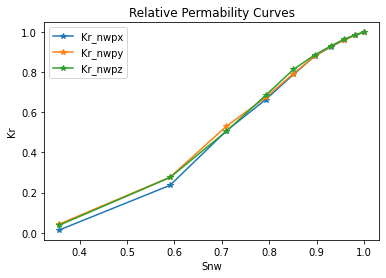

In [5]:
rp.plot_Kr_curves([0])

In order to get the relative permeability curves of both phases, we need to pass the defending phase as an argument to the algorithm.

[0]

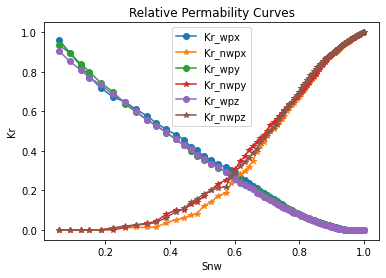

In [6]:
rp = op.algorithms.metrics.RelativePermeability(network=pn)
rp.setup(invading_phase='air', defending_phase='water',
         invasion_sequence='invasion_sequence')
rp.run()
rp.plot_Kr_curves([0])

The algorithm can also find the relative permeabilities of the phase(s) in the user-defined flow direction(s). The algorithm overwrites the flow inlets/outlets for the user-defined direction. Then calculates the relative permeability through the other directions from the default settings. This is illustrated as following.

[0]

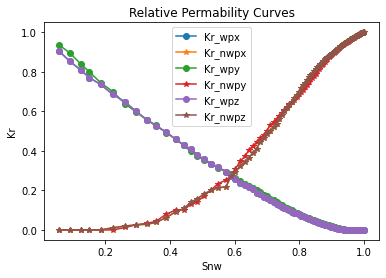

In [7]:
rp = op.algorithms.metrics.RelativePermeability(network=pn)
rp.setup(invading_phase='air', defending_phase='water',
         invasion_sequence='invasion_sequence',flow_inlets={'x': 'top'}, flow_outlets={'x': 'bottom'})
rp.run()
rp.plot_Kr_curves([0])

As we see both Kr values for the x and z direction are the same, because we changed the inlets/outlets in the x direction in such a way that it is equivalent to the algorithm default z direction. If we pass the flow intelts/outlets to the algorithm, the algorithm overwrites its default pores with the passed arguments corresponding to that direction. The same procedure cna be applied to a 2D model.

Note: The direction of the flow is found by finding the boundaries' corresponding cartesian coordinates direction. This rule also allows the user to define their boundary pores easily. As an example if the user defines the 'x' direction boundary pores, the algorithm overwrites the default boundary pores that were related to the 'x' direction. Any other possible boundaries (which is dependent on the shape of the network) will be automatically assigned to the default pores in the other direction. Note that the algorithm distinguishes whether a network is a 2D or not by looking at the number of boundary faces labeled. By doing so, the shape of the network is found and so does their corresponding default boundary pores. As mentioned before the algorithm will not plot the defending phase curves, if it is not passed as an argument (optional).